# Evaluation of ReInspect

Evaluation for end-to-end people detection in crowded scenes.

Let's start with importing the required files, seeding the random number generators and setting up the hyperparameters.

In [55]:
import cv2
import json
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imread
from IPython import display
import sys
sys.path.append('..')
import apollocaffe # Make sure that caffe is on the python path:

from utils.annolist import AnnotationLib as al
from train import load_idl, forward
from utils import load_data_mean, Rect, stitch_rects

In [56]:
config = json.load(open("crowd_test.json", 'r'))
print ("Test config file is " + config["data"]["test_idl"] )
apollocaffe.set_random_seed(config["solver"]["random_seed"])
apollocaffe.set_device(0)

Test config file is ./data/people/people_test.idl
2016-01-13 23:16:08 - GPU device 0


Now lets load the data mean and the data.

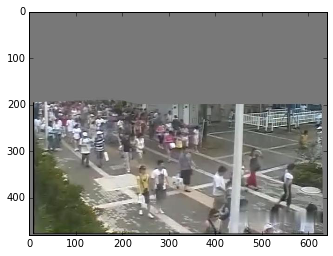

In [57]:
data_mean = load_data_mean(config["data"]["idl_mean"], 
                           config["net"]["img_width"], 
                           config["net"]["img_height"], image_scaling=1.0)

num_test_images = 5

# Warning: load_idl returns an infinite generator. Calling list() before islice() will hang.
test_list = list(itertools.islice(
        load_idl(config["data"]["test_idl"], data_mean, config["net"], False),
        0,
        num_test_images))
img = np.copy(test_list[-1]["raw"])
plt.imshow(img)

We can now load the snapshot weights.

We can now begin to run the model and visualize the results.

In [61]:
net = apollocaffe.ApolloNet()
net.phase = 'test'
forward(net, test_list[0], config["net"], True)
net.load("./data/snapshot/reinspect_noinit_20000.h5")

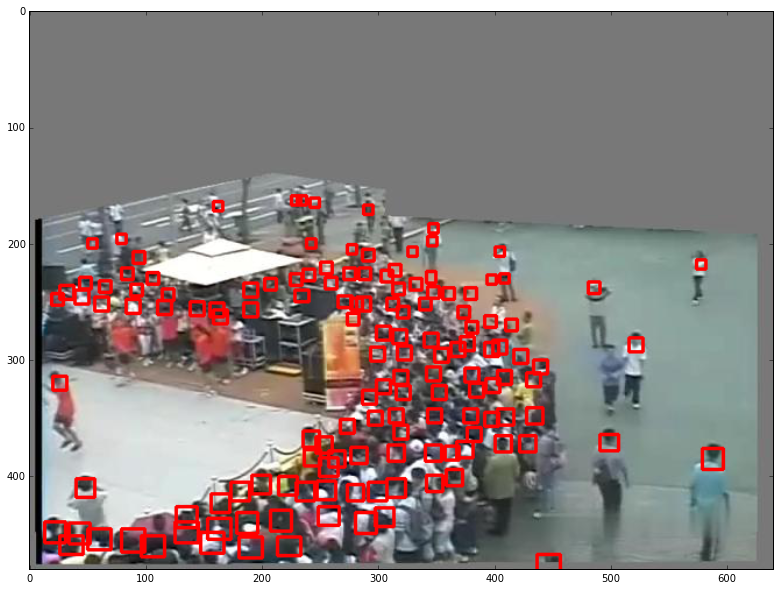

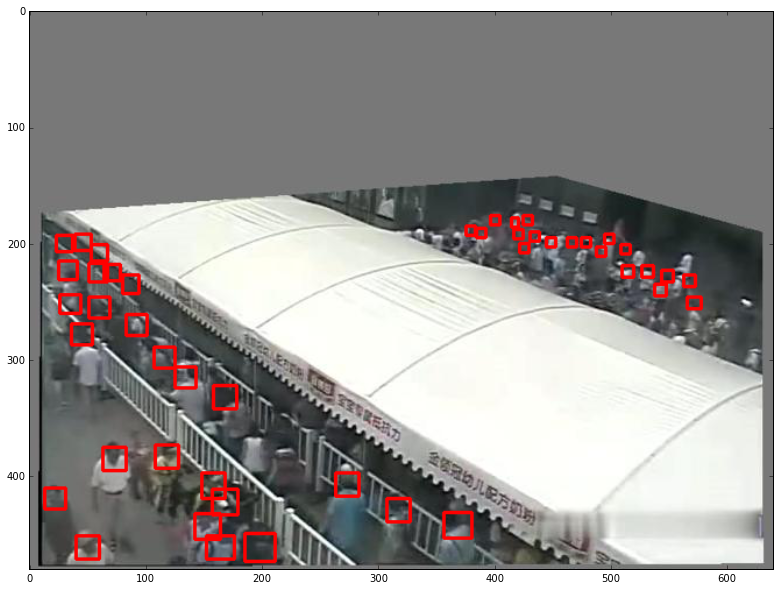

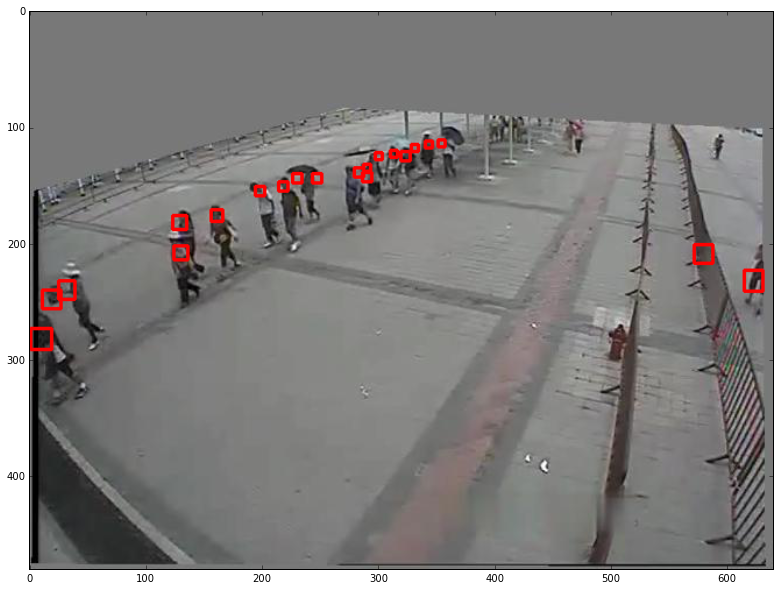

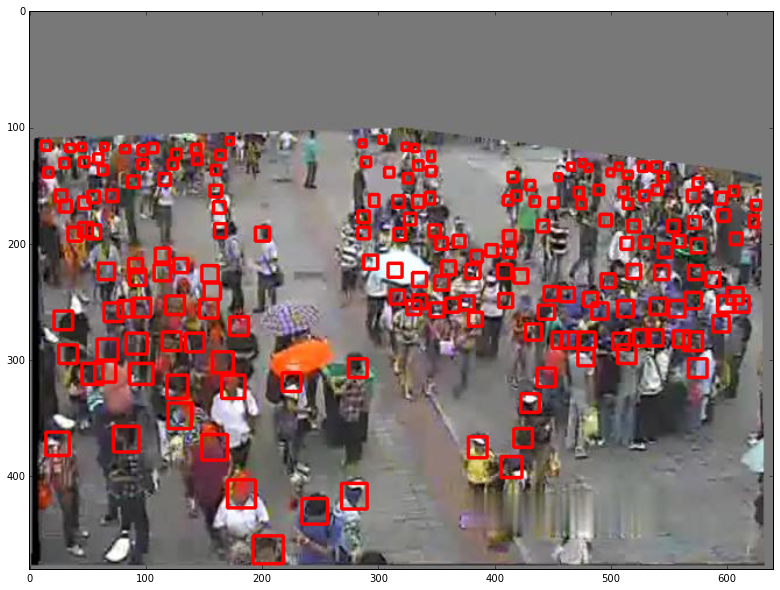

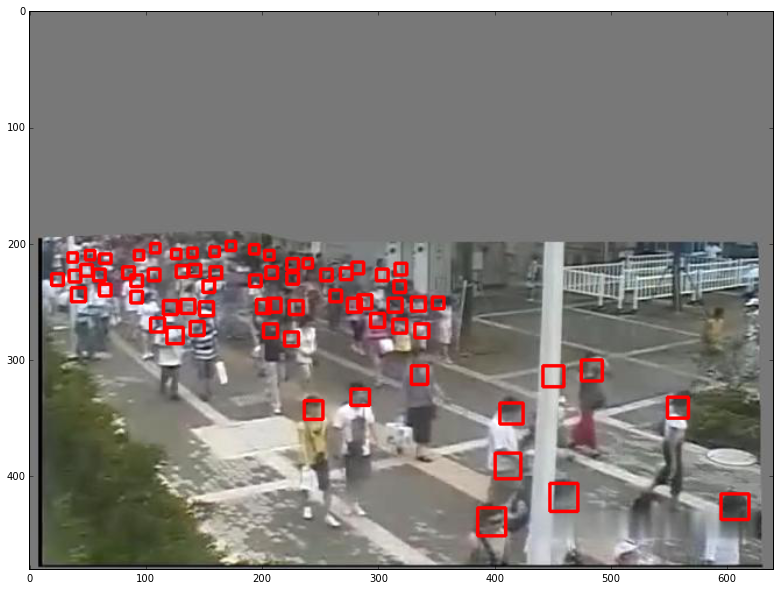

In [62]:
annolist = al.AnnoList()
net_config = config["net"]
pix_per_w = net_config["img_width"]/net_config["grid_width"]
pix_per_h = net_config["img_height"]/net_config["grid_height"]

for i in range(num_test_images):
    inputs = test_list[i]
    bbox_list, conf_list = forward(net, inputs, net_config, True)
    
    img = np.copy(inputs["raw"])
    png = np.copy(inputs["imname"])
    all_rects = [[[] for x in range(net_config["grid_width"])] for y in range(net_config["grid_height"])]
    for n in range(len(bbox_list)):
        for k in range(net_config["grid_height"] * net_config["grid_width"]):
            y = int(k / net_config["grid_width"])
            x = int(k % net_config["grid_width"])
            bbox = bbox_list[n][k]
            conf = conf_list[n][k,1].flatten()[0]
            w = bbox[2,0,0]
            h = bbox[3,0,0]
            abs_cx = pix_per_w/2 + pix_per_w*x + (bbox[0,0,0]) 
            abs_cy = pix_per_h/2 + pix_per_h*y + (bbox[1,0,0]) 
            all_rects[y][x].append(Rect(abs_cx,abs_cy,w,h,conf))

    acc_rects = stitch_rects(all_rects)
    
    display = True
    if display:
        for rect in acc_rects:
            # ignoring the low confidence ones
            if rect.true_confidence < 0.5:
                continue
            cv2.rectangle(img, 
                          (rect.cx-int(rect.width/2), rect.cy-int(rect.height/2)), 
                          (rect.cx+int(rect.width/2), rect.cy+int(rect.height/2)), 
                          (255,0,0),
                          2)
     
        plt.figure(figsize=(15,10))
        plt.imshow(img)
        
    anno = al.Annotation()
    anno.imageName = inputs["imname"]
    for rect in acc_rects:
        r = al.AnnoRect()
        r.x1 = rect.cx - rect.width/2.
        r.x2 = rect.cx + rect.width/2.
        r.y1 = rect.cy - rect.height/2.
        r.y2 = rect.cy + rect.height/2.
        r.score = rect.true_confidence
        anno.rects.append(r)
    annolist.append(anno)

In [20]:
annolist.save('/tmp/predictions_test.idl')

saving:  /tmp/predictions_test.idl


In [38]:
a = bbox_list[0][0]
print a.shape
print (a[0, 0, 0], a[1, 0, 0], a[2, 0, 0], a[3, 0, 0])
print round(a[0,0,0])

(4, 1, 1)
(-5.6886177, -22.701822, 18.633802, 27.207163)
-6.0
